In [1]:
import tensorflow as tf
import glob
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output

Segmentation Models: using `keras` framework.


In [2]:
#Resizing images is optional, CNNs are ok with large images
SIZE_X = 128 #Resize images (height  = X, width = Y)
SIZE_Y = 128

#Capture training image info as a list
train_images = []
train_masks = []

dataset_dr = "LabeledTomatoLeaves"

for directory_path in glob.glob(dataset_dr + "/images"):
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)  
        img = cv2.resize(img, (SIZE_X, SIZE_Y))     
        train_images.append(img)
        mask_path = img_path.replace('/images', '/labels').replace('.jpg', '.png')
        mask = cv2.imread(mask_path)
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X))
        train_masks.append(mask)
    for img_path in glob.glob(os.path.join(directory_path, "*.JPG")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)    
        img = cv2.resize(img, (SIZE_X, SIZE_Y))
        train_images.append(img)
        mask_path = img_path.replace('/images', '/labels').replace('.JPG', '.png')
        mask = cv2.imread(mask_path)
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X)) 
        train_masks.append(mask)
    for img_path in glob.glob(os.path.join(directory_path, "*.jpeg")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)    
        img = cv2.resize(img, (SIZE_X, SIZE_Y))   
        train_images.append(img)
        mask_path = img_path.replace('/images', '/labels').replace('.jpeg', '.png')
        mask = cv2.imread(mask_path)
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X))
        train_masks.append(mask)
#Convert list to array for machine learning processing        
train_images = np.array(train_images, dtype=object)
print(train_images.shape)

#Capture mask/label info as a list
# train_masks = [] 
# for directory_path in glob.glob(dataset_dr + "/labels"):
#     for mask_path in glob.glob(os.path.join(directory_path, "*.png")):
#         mask = cv2.imread(mask_path)       
#         # img = cv2.resize(img, (SIZE_X, SIZE_Y))
#         mask = cv2.resize(mask, (SIZE_Y, SIZE_X))
#         #mask = cv2.cvtColor(mask, cv2.COLOR_RGB2BGR)
#         train_masks.append(mask)
#         #train_labels.append(label)
# #Convert list to array for machine learning processing          
train_masks = np.array(train_masks, dtype=object)
print(train_masks.shape)

#Use customary x_train and y_train variables
X = train_images
Y = train_masks


from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

x_train = np.asarray(x_train).astype('float32')
x_val = np.asarray(x_val).astype('float32')
y_train = np.asarray(y_train).astype('float32')
y_val = np.asarray(y_val).astype('float32')

x_train = tf.convert_to_tensor(x_train)
x_val = tf.convert_to_tensor(x_val)
y_train = tf.convert_to_tensor(y_train)
y_val = tf.convert_to_tensor(y_val)

print(x_train.shape, x_val.shape)
print(y_train.shape, y_val.shape)

# plt.imshow(tf.keras.utils.array_to_img(y_train[0]))

(66, 128, 128, 3)
(66, 128, 128, 3)
Metal device set to: Apple M1
(52, 128, 128, 3) (14, 128, 128, 3)
(52, 128, 128, 3) (14, 128, 128, 3)


2023-03-10 15:24:14.811072: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-10 15:24:14.811640: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)



systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



In [3]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

from tensorflow_examples.models.pix2pix import pix2pix


up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [4]:
OUTPUT_CLASSES = 3

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

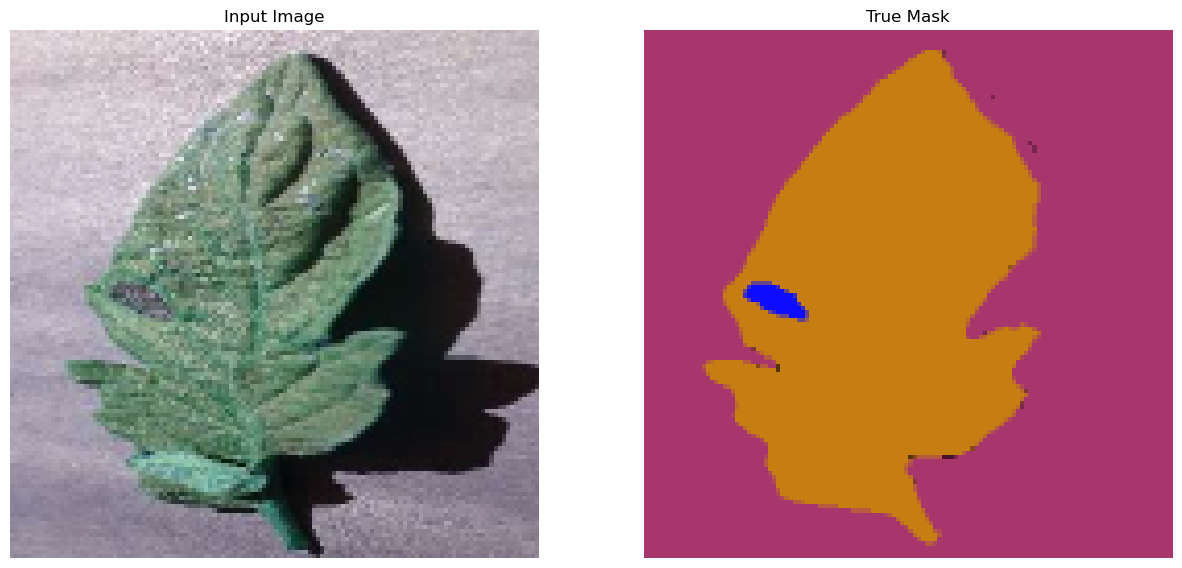

In [5]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

# for images, masks in train_batches.take(2):
#   sample_image, sample_mask = images[0], masks[0]
#   display([sample_image, sample_mask])
display([x_train[0], y_train[0]])

2023-03-10 15:24:16.406095: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-03-10 15:24:16.726738: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 742ms/step


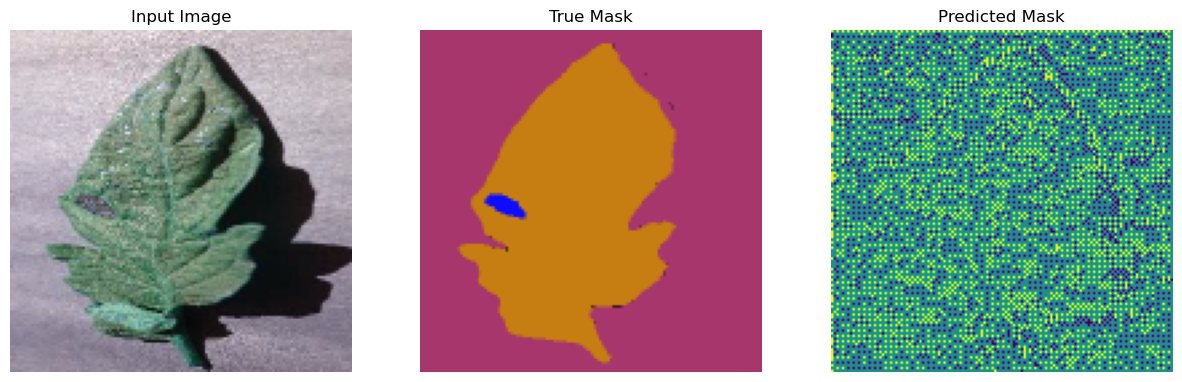

In [6]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

sample_image = x_train[0]
sample_mask = y_train[0]
show_predictions()
# print(sample_image.shape)
# model.predict(sample_image[tf.newaxis, ...])

1/1 [==============================] - 0s 79ms/step


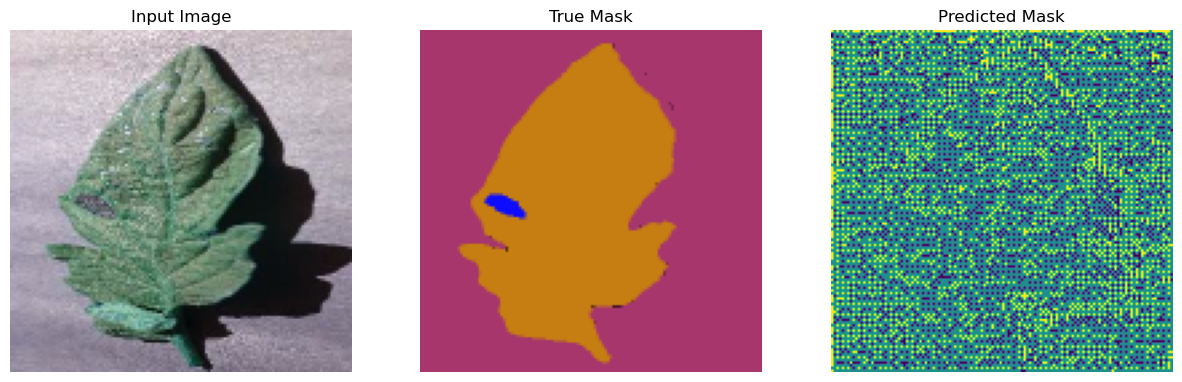


Sample Prediction after epoch 1

7/7 [==============================] - 5s 382ms/step - loss: 508.5892 - accuracy: 0.1595 - val_loss: 514.3956 - val_accuracy: 0.1814


In [7]:
VAL_SUBSPLITS = 5
# VALIDATION_STEPS = VALIDATION_LENGTH//BATCH_SIZE//VAL_SUBSPLITS

# model_history = model.fit(train_batches, epochs=EPOCHS,
#                           steps_per_epoch=STEPS_PER_EPOCH,
#                           validation_steps=VALIDATION_STEPS,
#                           validation_data=test_batches,
#                           callbacks=[DisplayCallback()])
EPOCHS = 1
history = model.fit(
    x_train, 
    y_train,
    batch_size=8,
    epochs=EPOCHS,
    validation_data=(x_val, y_val),
    callbacks=[DisplayCallback()]
)

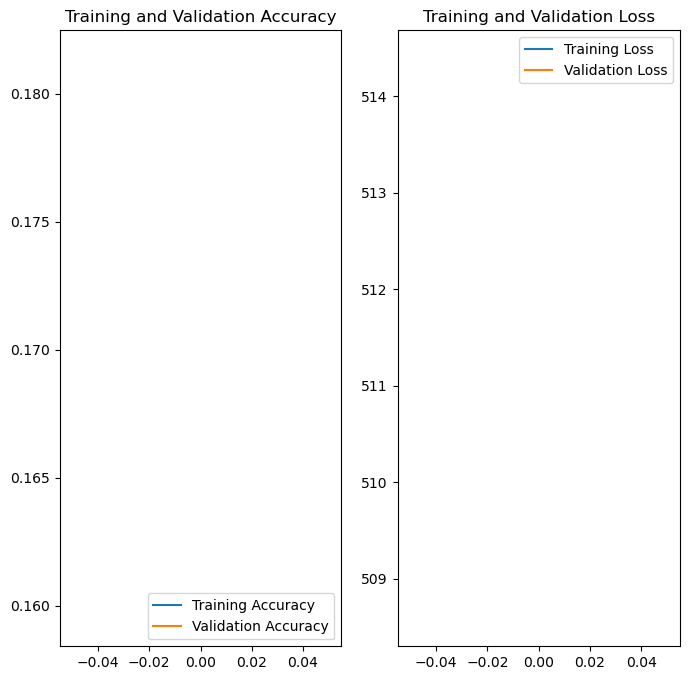

In [8]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()